In [1]:

import pyedflib
file_name = "by captain borat/raw/EEG_0_per_hour_2024-03-20 17_12_18.edf"
try:
        f = pyedflib.EdfReader(file_name)
        n = f.signals_in_file
        signal_labels = f.getSignalLabels()
        n_samples = f.getNSamples()[0]
        data = f.readSignal(0)
        print(f"Archivo: {file_name}")
        print(f"Número de señales: {n}")
        print("Etiquetas de señal:", signal_labels)
        print(f"Muestras en la primera señal: {n_samples}")
        f._close()
except Exception as e:
        print(f"Error al leer el archivo EDF: {e}")


Archivo: by captain borat/raw/EEG_0_per_hour_2024-03-20 17_12_18.edf
Número de señales: 1
Etiquetas de señal: ['Temp']
Muestras en la primera señal: 44153856


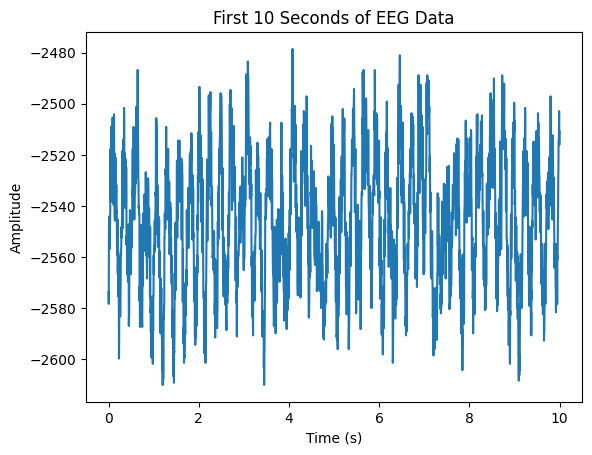

In [ ]:
import matplotlib.pyplot as plt

# Plot the first 10 seconds of data
fs = 512  # Assuming a sampling frequency of 512 Hz
time = [i / fs for i in range(10 * fs)]  # Generate time vector for 10 seconds
plt.plot(time, data[:10 * fs])
plt.title("First 10 Seconds of EEG Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()



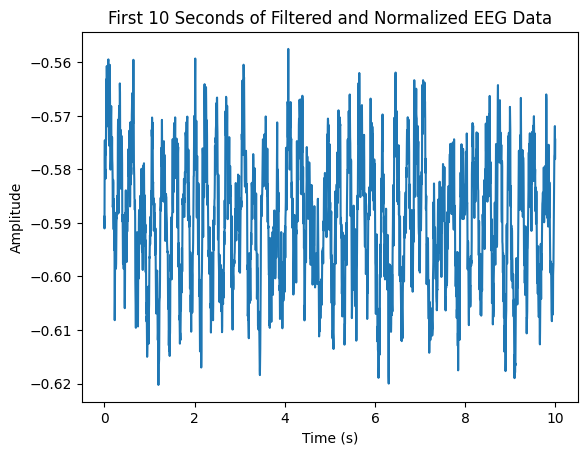

In [3]:
from scipy.signal import butter, filtfilt

# Band-pass filter function
def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

# Apply band-pass filter
filtered_data = bandpass_filter(data, 0.5, 100, fs)

# Normalize the data between -1 and 1
normalized_data = 2 * (filtered_data - min(filtered_data)) / (max(filtered_data) - min(filtered_data)) - 1

# Plot the first 10 seconds of the normalized data
plt.plot(time, normalized_data[:10 * fs])
plt.title("First 10 Seconds of Filtered and Normalized EEG Data")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

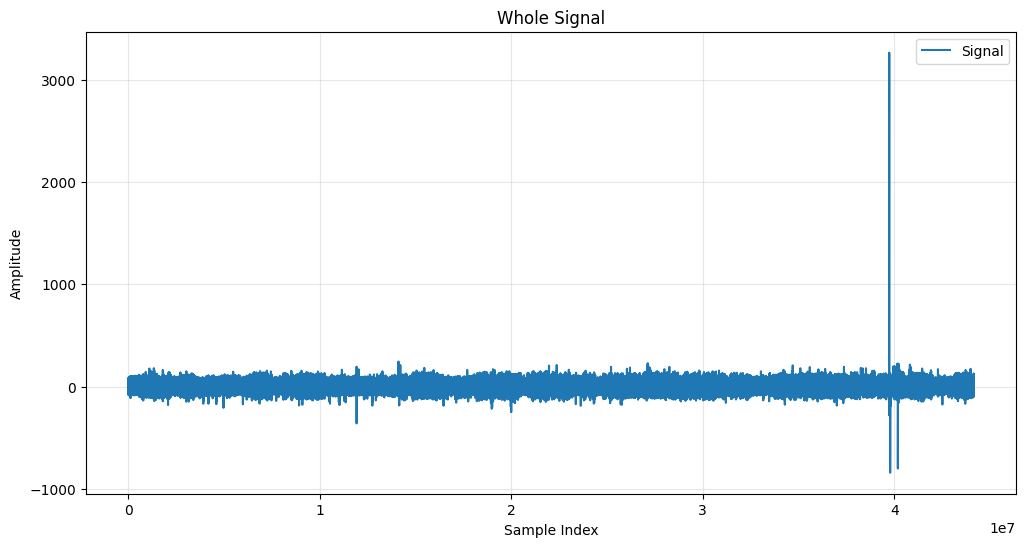

In [4]:
plt.figure(figsize=(12, 6))
plt.plot(filtered_data, label="Signal")
plt.title("Whole Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [5]:
# Calculate the number of samples for the first 20 minutes
samples_20mins = 20 * 60 * fs  # 20 minutes * 60 seconds * sampling frequency

# Extract the first 20 minutes of the filtered signal
filtered_data_20mins = filtered_data[:samples_20mins]

# Print the length of the extracted data to verify
print(f"Length of the extracted data: {len(filtered_data_20mins)} samples")

Length of the extracted data: 307200 samples


In [27]:
work_data=filtered_data

In [6]:
import importlib

for module in ['kooplearn']:
    try:
        importlib.import_module(module)
    except ImportError:
      if module == 'kooplearn':
        module = 'kooplearn[full]'
      %pip install -q {module}

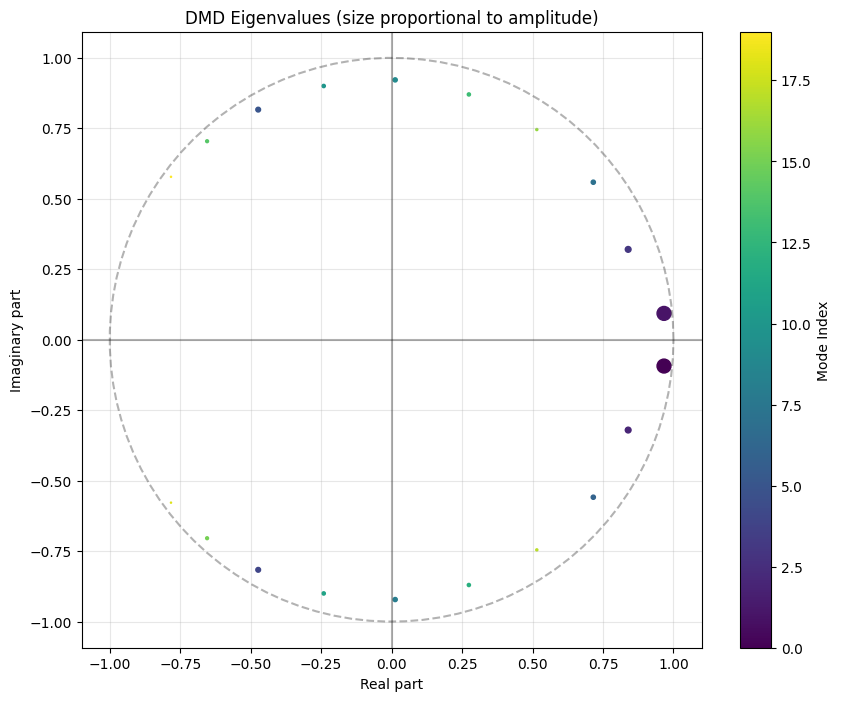

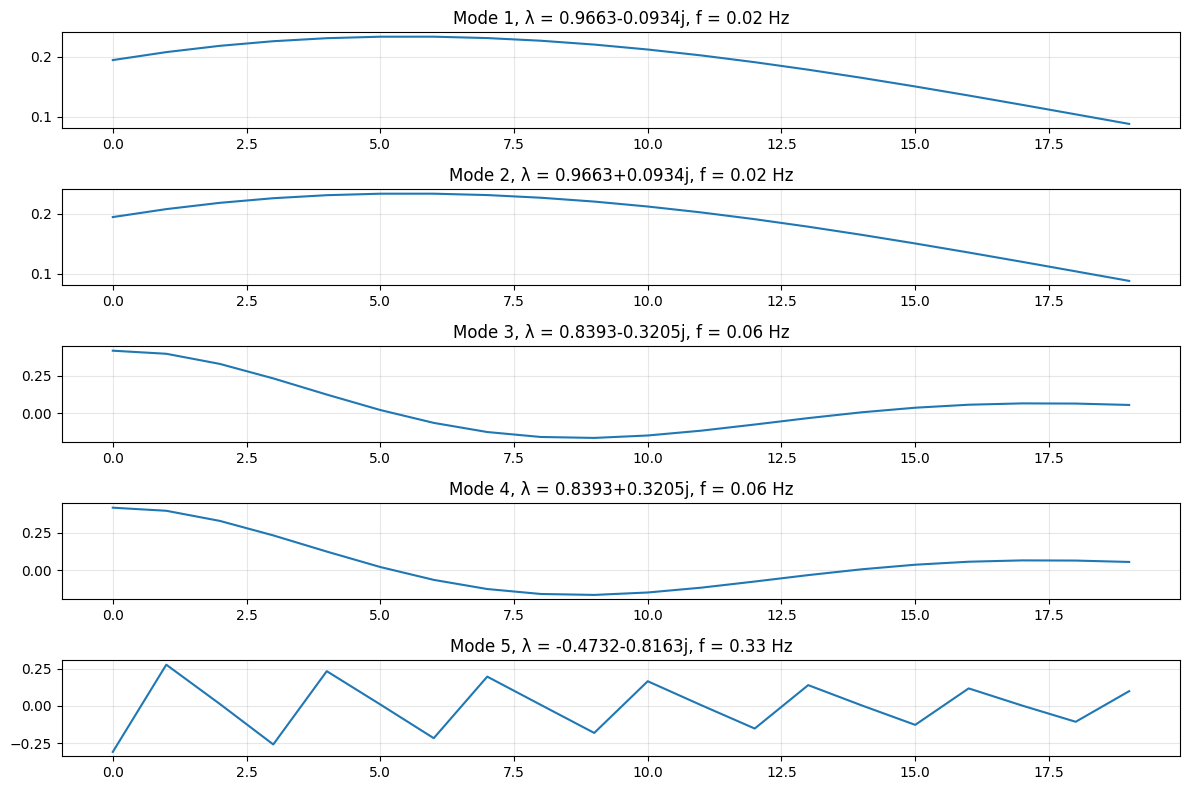

Dominant modes analysis:
Mode 1:
  λ = 0.9663-0.0934j
  Frequency: 0.02 Hz
  Growth/Decay: -0.0296
  Amplitude: 147.0395

Mode 2:
  λ = 0.9663+0.0934j
  Frequency: 0.02 Hz
  Growth/Decay: -0.0296
  Amplitude: 147.0395

Mode 3:
  λ = 0.8393-0.3205j
  Frequency: 0.06 Hz
  Growth/Decay: -0.1071
  Amplitude: 25.3329

Mode 4:
  λ = 0.8393+0.3205j
  Frequency: 0.06 Hz
  Growth/Decay: -0.1071
  Amplitude: 25.3329

Mode 5:
  λ = -0.4732-0.8163j
  Frequency: 0.33 Hz
  Growth/Decay: -0.0582
  Amplitude: 17.1174



/mnt/hubel-data-103/Yahia/Physionet_data/.venv/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


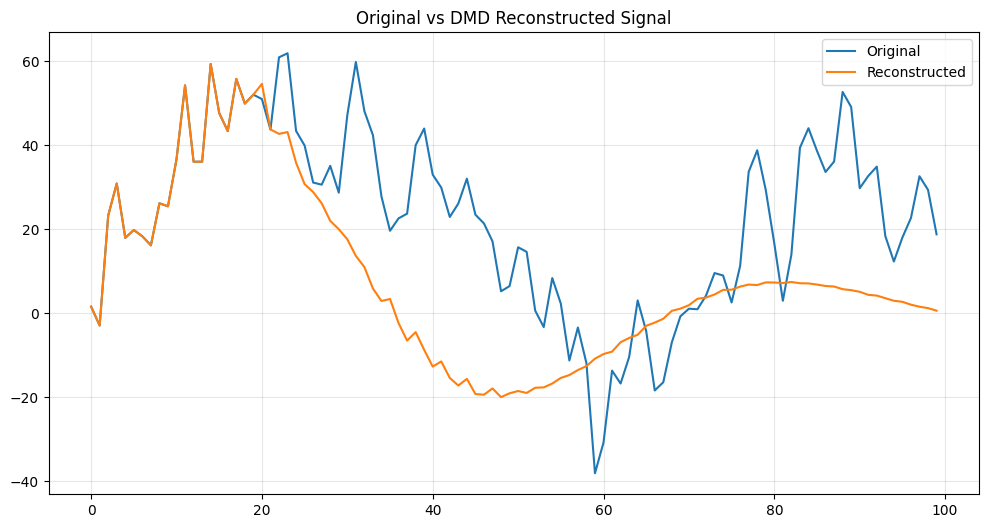

Relative reconstruction error: 0.9999


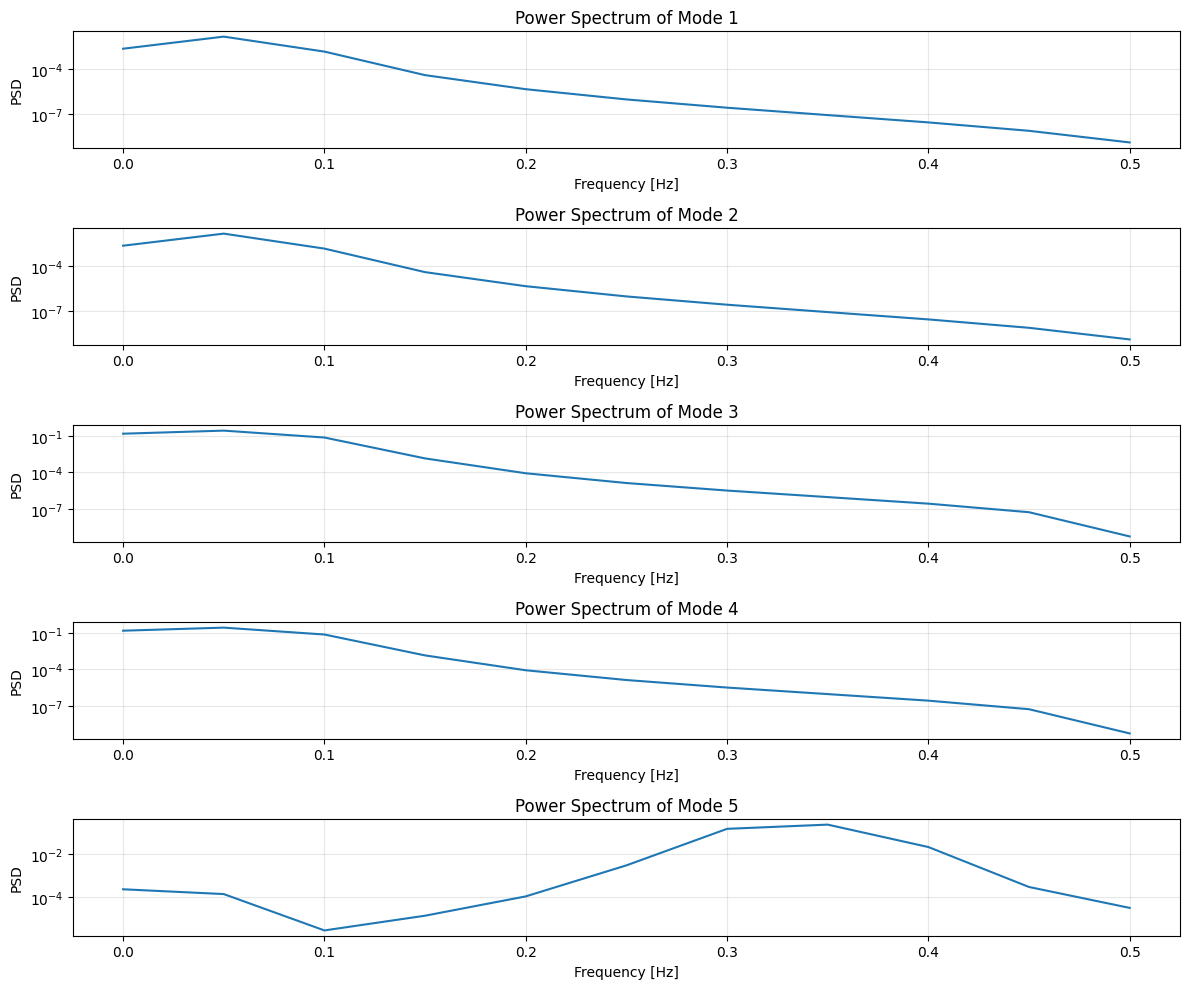

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pydmd import DMD
from scipy.signal import detrend

# Assuming work_data is already loaded and preprocessed
# work_data shape should be (n_samples,) for single channel EEG

# Make sure work_data is a proper numpy array
if not isinstance(work_data, np.ndarray):
    work_data = np.array(work_data)

# Prepare data for DMD analysis
# For single channel data, we'll create a Hankel matrix
def create_hankel_matrix(data, embedding_dim):
    """Create a Hankel matrix from 1D time series data"""
    n_samples = len(data) - embedding_dim + 1
    hankel = np.zeros((embedding_dim, n_samples))
    for i in range(embedding_dim):
        hankel[i, :] = data[i:i+n_samples]
    return hankel

# Remove trend from the data
detrended_data = detrend(work_data)

# Create Hankel matrix
embedding_dim = 20  # Adjust based on your data characteristics
X = create_hankel_matrix(detrended_data, embedding_dim)

# Apply DMD
dmd = DMD(svd_rank=-1)  # -1 means use all modes
dmd.fit(X)

# Get eigenvalues and modes
eigenvalues = dmd.eigs
modes = dmd.modes
frequencies = dmd.frequency
growth_rates = dmd.amplitudes

# Sort by amplitude
idx = np.argsort(np.abs(growth_rates))[::-1]
sorted_eigenvalues = eigenvalues[idx]
sorted_modes = modes[:, idx]
sorted_frequencies = frequencies[idx]
sorted_growth_rates = growth_rates[idx]

# Plot the eigenvalues in the complex plane
plt.figure(figsize=(10, 8))
plt.scatter(np.real(sorted_eigenvalues), np.imag(sorted_eigenvalues), 
           c=np.arange(len(sorted_eigenvalues)), cmap='viridis', s=100*np.abs(sorted_growth_rates)/np.max(np.abs(sorted_growth_rates)))
plt.colorbar(label='Mode Index')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.grid(alpha=0.3)
plt.xlabel('Real part')
plt.ylabel('Imaginary part')
plt.title('DMD Eigenvalues (size proportional to amplitude)')

# Plot the unit circle
theta = np.linspace(0, 2*np.pi, 100)
circle_x = np.cos(theta)
circle_y = np.sin(theta)
plt.plot(circle_x, circle_y, 'k--', alpha=0.3)
plt.axis('equal')
plt.show()

# Plot the dominant modes
n_modes = 5
plt.figure(figsize=(12, 8))
for i in range(n_modes):
    mode = np.real(sorted_modes[:, i])
    plt.subplot(n_modes, 1, i+1)
    plt.plot(mode)
    plt.title(f'Mode {i+1}, λ = {sorted_eigenvalues[i]:.4f}, f = {np.abs(sorted_frequencies[i]):.2f} Hz')
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Print the dominant modes information
print("Dominant modes analysis:")
for i in range(n_modes):
    print(f"Mode {i+1}:")
    print(f"  λ = {sorted_eigenvalues[i]:.4f}")
    print(f"  Frequency: {np.abs(sorted_frequencies[i]):.2f} Hz")
    print(f"  Growth/Decay: {np.log(np.abs(sorted_eigenvalues[i])):.4f}")
    print(f"  Amplitude: {np.abs(sorted_growth_rates[i]):.4f}")
    print()

# Reconstruct the signal
reconstructed = dmd.reconstructed_data
orig_dim = X.shape[0]
orig_samples = X.shape[1]

# Compare original vs reconstructed for first row
plt.figure(figsize=(12, 6))
plt.plot(X[0, :100], label='Original')
plt.plot(reconstructed[0, :100], label='Reconstructed')
plt.legend()
plt.title('Original vs DMD Reconstructed Signal')
plt.grid(alpha=0.3)
plt.show()

# Calculate and plot reconstruction error
error = np.linalg.norm(X - reconstructed, 'fro') / np.linalg.norm(X, 'fro')
print(f"Relative reconstruction error: {error:.4f}")

# Analyze frequency content of modes
from scipy import signal

# Analyze frequency content of the top modes
plt.figure(figsize=(12, 10))
for i in range(n_modes):
    mode = np.real(sorted_modes[:, i])
    f, Pxx = signal.welch(mode, fs=1.0, nperseg=min(256, len(mode)))
    
    plt.subplot(n_modes, 1, i+1)
    plt.semilogy(f, Pxx)
    plt.title(f'Power Spectrum of Mode {i+1}')
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD')
    plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, butter, filtfilt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from pydmd import DMD


2025-04-07 15:37:34.367179: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 15:37:34.369620: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 15:37:34.412824: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-07 15:37:34.414113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 15:37:36.518837: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [ ]:

# PART 1: Preprocess the EEG signal
def preprocess_eeg(signal, fs=256):
    """Preprocess the EEG signal with filtering and normalization"""
    # Apply bandpass filter (0.5-30 Hz for sleep EEG)
    nyq = 0.5 * fs
    low = 0.5 / nyq
    high = 100.0 / nyq
    b, a = butter(3, [low, high], btype='band')
    filtered = filtfilt(b, a, signal)
    
    # Detrend to remove linear trends
    detrended = detrend(filtered)
    
    # Normalize
    normalized = StandardScaler().fit_transform(detrended.reshape(-1, 1)).flatten()
    
    return normalized


In [16]:

# PART 2: Create windowed segments for analysis
def create_windows(signal, window_size=30*256, overlap=0.5):
    """Create overlapping windows from the signal"""
    step = int(window_size * (1 - overlap))
    n_windows = (len(signal) - window_size) // step + 1
    windows = np.zeros((n_windows, window_size))
    
    for i in range(n_windows):
        start = i * step
        windows[i] = signal[start:start+window_size]
        
    return windows


In [17]:

# PART 3: Apply DMD to extract features
def extract_dmd_features(windows, rank=10, embedding_dim=20):
    """Extract DMD features from signal windows"""
    n_windows = windows.shape[0]
    
    # Prepare feature arrays
    eigenvalues_real = np.zeros((n_windows, rank))
    eigenvalues_imag = np.zeros((n_windows, rank))
    amplitudes = np.zeros((n_windows, rank))
    frequencies = np.zeros((n_windows, rank))
    
    for i in range(n_windows):
        # Create Hankel matrix (time-delay embedding)
        window = windows[i]
        hankel = np.zeros((embedding_dim, len(window) - embedding_dim + 1))
        for j in range(embedding_dim):
            hankel[j, :] = window[j:j+hankel.shape[1]]
        
        # Apply DMD
        dmd = DMD(svd_rank=rank)
        dmd.fit(hankel)
        
        # Sort by amplitude
        idx = np.argsort(np.abs(dmd.amplitudes))[::-1][:rank]
        sorted_eigs = dmd.eigs[idx]
        sorted_amps = np.abs(dmd.amplitudes[idx])
        sorted_freqs = np.abs(dmd.frequency[idx])
        
        # Store features
        eigenvalues_real[i] = np.real(sorted_eigs)
        eigenvalues_imag[i] = np.imag(sorted_eigs)
        amplitudes[i] = sorted_amps
        frequencies[i] = sorted_freqs
    
    # Combine features
    features = np.hstack((eigenvalues_real, eigenvalues_imag, amplitudes, frequencies))
    return features


In [18]:

# PART 4: Unsupervised clustering for sleep stages
def cluster_sleep_stages(features, n_clusters=5):
    """Cluster DMD features into sleep stages"""
    # Dimensionality reduction with t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features)
    
    # K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    labels = kmeans.fit_predict(features)
    
    # Visualize clusters
    plt.figure(figsize=(10, 8))
    for i in range(n_clusters):
        plt.scatter(features_2d[labels == i, 0], features_2d[labels == i, 1], label=f'Cluster {i}')
    plt.legend()
    plt.title('Sleep Stage Clusters')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    plt.show()
    
    return labels, features_2d


In [19]:

# PART 5: Build deep learning model for micro-arousal detection
def build_micro_arousal_model(input_shape, learning_rate=0.001):
    """Build a deep learning model for micro-arousal detection"""
    model = Sequential([
        LSTM(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model


In [20]:

# PART 6: Detect transition points for micro-arousals
def detect_transitions(labels, threshold=0.8):
    """Detect potential micro-arousals from stage transitions"""
    transitions = []
    
    # Compute transition probability between consecutive windows
    for i in range(1, len(labels)):
        if labels[i] != labels[i-1]:
            transitions.append(i)
    
    return transitions


In [21]:

# PART 7: Full analysis pipeline
def analyze_sleep_eeg(signal, fs=256):
    """Complete analysis pipeline for sleep EEG"""
    # Step 1: Preprocess
    preprocessed = preprocess_eeg(signal, fs)
    
    # Step 2: Create windows
    window_size = 30 * fs  # 30 seconds is standard for sleep staging
    windows = create_windows(preprocessed, window_size, overlap=0.5)
    
    # Step 3: Extract DMD features
    features = extract_dmd_features(windows, rank=20, embedding_dim=30)
    
    # Step 4: Cluster sleep stages
    labels, features_2d = cluster_sleep_stages(features, n_clusters=5)
    
    # Step 5: Detect potential micro-arousals from transitions
    transitions = detect_transitions(labels)
    
    # Step 6: Visualize results
    plt.figure(figsize=(15, 10))
    
    # Plot hypnogram
    plt.subplot(3, 1, 1)
    plt.plot(labels, drawstyle='steps-post')
    plt.title('Sleep Stage Hypnogram')
    plt.ylabel('Stage')
    plt.xlabel('Window Index')
    
    # Mark transitions
    for t in transitions:
        plt.axvline(x=t, color='r', alpha=0.3)
    
    # Plot original signal segment
    plt.subplot(3, 1, 2)
    t = np.arange(len(preprocessed)) / fs
    plt.plot(t[:1000], preprocessed[:1000])
    plt.title('EEG Signal Segment')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Plot t-SNE of features with trajectory
    plt.subplot(3, 1, 3)
    plt.scatter(features_2d[:, 0], features_2d[:, 1], c=labels, cmap='viridis')
    plt.plot(features_2d[:, 0], features_2d[:, 1], 'k-', alpha=0.3)
    plt.title('DMD Feature Space (t-SNE)')
    plt.xlabel('t-SNE dimension 1')
    plt.ylabel('t-SNE dimension 2')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'features': features,
        'labels': labels, 
        'transitions': transitions
    }


In [28]:
# Assuming your EEG data is in work_data and sampled at 256 Hz
patterns, sleep_results = analyze_sleep_eeg(work_data, fs=512)

/mnt/hubel-data-103/Yahia/Physionet_data/.venv/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 21212558512.286224. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/mnt/hubel-data-103/Yahia/Physionet_data/.venv/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 20607219836.843407. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/mnt/hubel-data-103/Yahia/Physionet_data/.venv/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 21364312037.91185. Consider preprocessing data, passing in augmented data
matrix, or regularization methods.
  warnings.warn(
/mnt/hubel-data-103/Yahia/Physionet_data/.venv/lib/python3.8/site-packages/pydmd/snapshots.py:73: UserWarning: Input data condition number 22432769901.41041. Consider preprocessing data, passing in augme

KeyboardInterrupt: 